In [2]:
%run ../setup.ipynb

# Comparing to sinusoids

In this section, we'll begin to build up the foundations of the Fourier transform and the frequency domain.
As stated in the introduction to this chapter, the entire idea of the Fourier transform is to represent arbitrary signals $x[n]$ as combinations of sinusoids:

$$
\begin{align*}
x[n] &= A_0 \cdot \cos\left(2\pi \cdot f_0 \cdot \frac{n}{f_s} + \phi_0\right) \\
&+ A_1 \cdot \cos\left(2\pi \cdot f_1 \cdot \frac{n}{f_s} + \phi_1\right) \\
&+ \dots
\end{align*}
$$

Before we go any further with this idea, it is helpful to think carefully about what it would mean to represent an arbitrary discrete signal $x[n]$ in this way.

```{warning}
The representation that we develop in this section is **not** the Fourier transform. 

This section will set up the foundations that we'll need to define the Fourier transform later in this chapter.
There is plenty to cover, but your patience will be rewarded!
```

## Band-limiting

Since $x[n]$ is a discrete signal taken at some sampling rate $f_s$, we will assume that the conditions of the Nyquist-Shannon theorem hold and that aliasing is not going to be a problem for us.
More specifically, this means that we are assuming that the underlying continuous signal $x(t)$ which produced $x[n]$ is **band-limited** to the frequency range $\pm \frac{f_s}{2}$.
This implies that when representing $x[n]$, we will not need to use frequencies outside of this range.

That said, there are still infinitely many frequencies in the range $[-f_s/2, f_s/2]$ (e.g., 1 Hz, 1/2 Hz, 1/4 Hz, ...), and we can't compare to all of them and still have a finite representation of the signal.
We'll need to be careful in choosing which frequencies we compare to!

(dft-periodicity)=
## Periodicity

Recall back in {ref}`chapter 1 <periodicity>` that periodic signals must repeat forever, and this includes the sinusoids that will form the basis of any frequency-domain representation.
This also carries through to (finite) combinations of sinusoids.
Any signal that we try to represent as a combination of sinusoids, therefore, must also be assumed to be periodic.
```{margin} Finite vs infinite?
Things get weird when we allow for infinitely many sinusoids.

Fortunately, computers (like ourselves) are finite in nature, so let's not worry about it.
```

This presents a bit of a problem for us, as up to now, we've been assuming that signals are silent for all negative time: $x[n] = 0$ for $n < 0$.
A (non-empty) signal with an infinitely long stretch of silence cannot be periodic, so what can we do?

To make progress here, we'll need to change our assumptions.
Rather than assume that signals are silent for all time before recording, we'll assume that a finite signal $x[0], x[1], \dots, x[N-1]$ represents one cycle of a loop that repeats forever.
Under this assumption, once we've observed these $N$ samples, there is nothing new to learn from further observation, since the repetition assumption gives us for any sample index $n$:

````{margin} Array indexing
More generally, we can assume

```{math}
x[n] = x[n \mod N]
```

where $n\mod N$ is the remainder of dividing $n$ by $N$.

In Python, this is done by saying

```{code}
x[n % N]
```

Python also allows us to use negative array indices (up to -N) directly to index from the end of the array:
```{code}
x[-1]  # Last sample
```
````

```{math}
:label: periodicity-assumption

x[n] = x[n + N] = x[n + 2\cdot N] = \dots = x[n + k \cdot N] \quad\quad \text{for any } k \in \mathbb{Z}
```

This also gives a new view to negative sample indices as offsets from the end of the signal:

```{math}
:label: negative-samples

x[-n] = x[-n+N] = x[N-n]
```


This assumption is demonstrated visually below, where signal $x[n]$ of duration $1.5$ seconds (sampled at $f_s=100$, so $N=150$) is shown along with its implied repetitions.
These repetitions are implied to go on forever in each direction of time.
Note that the repeating signal need not be continuous at the repetition boundaries: all that matters is that the observed signal repeats exactly.

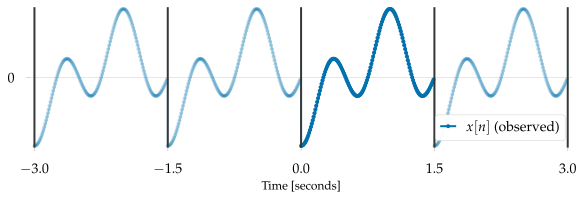

In [8]:
# Plot a repeating signal
fig, ax = plt.subplots(figsize=figaspect(1./3))

fs = 100

t = np.arange(-3 * fs, 3. * fs) / fs

f0 = 1.5
f1 = 1/2

x_part = np.cos(2 * np.pi * f0 * t[:int(f0 * fs)]) + np.cos(2 * np.pi * f1 * t[:int(f0 * fs)])
x_full = np.tile(x_part, 4)

ax.step(t, x_full, alpha=0.25, marker='.', where='post')
ax.step(t[3*fs:int(4.5*fs)], x_part, label=r'$x[n]$ (observed)', color=colors[0], where='post', marker='.')
ax.vlines([-3, -1.5, 0, 1.5, 3], -3, 3, colors=colors[3], zorder=3)
ax.legend(loc='lower right')
ax.set_ylim([-2.05, 2.05])
ax.set_xlim([-3.05, 3.05])
ax.set_yticks([0])
ax.set_xticks([-3, -1.5, 0, 1.5, 3])
ax.set_xlabel('Time [seconds]');
glue("sig_repeat", fig, display=False);

```{glue:figure} sig_repeat

A signal $x[n]$ of some finite number of samples $N$ (dark curve) is assumed to repeat forever (light curve).
Vertical lines denote the boundaries of each repetition of $x$.
```

## Choosing reference frequencies

As mentioned above, even though we're assuming $x[n]$ represents a band-limited signal, there are still infinitely many frequencies within the band.
Our periodicity assumption will help us narrow this down to a finite set that we can use to form our reference signals.

In the plot above, we see several identical repetitions of the observed signal $x[n]$.
Imagine comparing the full repeating signal to a sinusoid of some frequency $f$, and computing the {ref}`similarity score <similarity-score>` independently for each individual repetition. 
Ideally, it should not matter which repetition of $x$ we look at: they should all produce the same similarity score.
Unfortunately, this is not the case.

For example, if we take $f=1~[\text{Hz}]$ to get a reference signal

$$
y[n] = \cos\left(2 \pi \cdot \frac{n}{f_s}\right)
$$

we would observe the following:

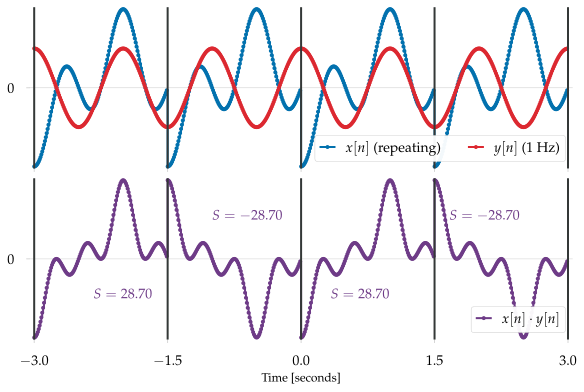

In [7]:
# Plot a repeating signal
fig, (ax, ax2) = plt.subplots(nrows=2, figsize=figaspect(2./3), sharex=True, sharey=True)

fs = 100

t = np.arange(-3 * fs, 3. * fs) / fs

f0 = 1.5
f1 = 1/2

x_part = np.cos(2 * np.pi * f0 * t[:int(f0 * fs)]) + np.cos(2 * np.pi * f1 * t[:int(f0 * fs)])
x_full = np.tile(x_part, 4)

ref = np.cos(2 * np.pi * 1 * t)

ax.step(t, x_full, label=r'$x[n]$ (repeating)', marker='.', where='post')
ax.step(t, ref, label=r'$y[n]$ (1 Hz)', marker='.', where='post')
ax.vlines([-3, -1.5, 0, 1.5, 3], -3, 3, colors=colors[3], zorder=3)
ax.legend(loc='lower right', ncol=2)
ax.set_ylim([-2.05, 2.05])
ax.set_xlim([-3.05, 3.05])
ax.label_outer();

xsim = x_full * ref

ax2.step(t, xsim, color=colors[4], label=r'$x[n] \cdot y[n]$', marker='.', where='post')
ax2.vlines([-3, -1.5, 0, 1.5, 3], -3, 3, colors=colors[3], zorder=3)

for i in range(4):
    ps = xsim[int(i * f0 * fs):int((i + 1) * f0 * fs)].sum()
    ax2.text(-3 + 2 * (i+0.5) / f0, (-1)**(i+1), '$S={:.2f}$'.format(ps), color=colors[4])

ax2.set_yticks([0])
ax2.set_xticks([-3, -1.5, 0, 1.5, 3])
ax2.legend(loc='lower right')
ax2.set_xlabel('Time [seconds]');
glue('badsim', fig, display=False)

```{glue:figure} badsim
Top: a repeating signal $x$ and a reference sinusoid $y$.
Bottom: each repetition of $x$ produces a different similarity score when compared to the corresponding segment of the reference signal $y$.
```

Each repetition of the signal $x[n]$ produces a different similarity score when compared to the 1 Hz reference signal, alternating between $+28.7$ and $-28.7$.
As a result, it's unclear how we should define the similarity between $x$ and $y$: if it's the similarity between one repetition, which one do we choose?  Or do we combine scores from multiple repetitions, and if so, how would that work if they go on forever?
In this example, we only had two distinct score values to deal with, but it's possible to construct examples where there are many more than that.

This problem arises because the period if the reference signal (1 second) does not line up with the period $x$, so the reference signal appears to start at a different point within each repetition.
In the figure, we observe the reference signal starting either high (1) or low (-1) in alternating repetitions of $x$.

If we can ensure that the reference signal always starts at the exact same position in each repetition of $x$, then the problem vanishes: each repetition will produce the same similarity score, so we only need to examine one of them.
This observation leads us to the concept of an *analysis frequency*.

````{admonition} Definition: Analysis frequency
:class: important

For a sampling rate $f_s$ and a signal length $N$, an **analysis frequency** $f_m$ is any frequency which exactly completes a whole (integer) number of cycles $m$ in $N$ samples at $f_s$.

Equivalently:

```{math}
:label: analysis-frequency

\begin{align*}
f_m &= \frac{m}{N}\cdot f_s \left[\frac{\text{cycles}}{\text{sec.}} \right] & \quad\quad m = 0, 1, 2, \dots
\end{align*}
```
````

Since we will be sampling waves at these frequencies at rate $f_s$ over the full signal duration $N$, it is sometimes more useful to think of analysis frequencies in units of ``[cycles / signal-duration]``, or in the notation above, the ratio $m/N$.

Analysis frequencies have exactly the characteristic that we want: a shift by $N$ samples will leave the signal unchanged, so each repetition of $x$ is guaranteed to produce the same similarity score.
For example, if we had chosen $m=1$ (one cycle per signal duration) so that $f = 1/N \cdot f_s$ (1.5 Hz for this case), we'd observe the following result:

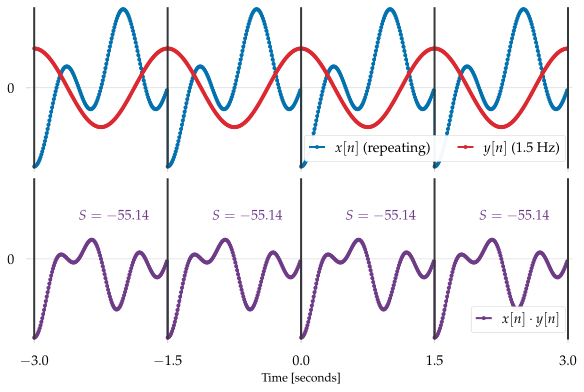

In [9]:
# Plot a repeating signal
fig, (ax, ax2) = plt.subplots(nrows=2, figsize=figaspect(2./3), sharex=True, sharey=True)

fs = 100

t = np.arange(-3 * fs, 3. * fs) / fs

f0 = 1.5
f1 = 1/2

x_part = np.cos(2 * np.pi * f0 * t[:int(f0 * fs)]) + np.cos(2 * np.pi * f1 * t[:int(f0 * fs)])
x_full = np.tile(x_part, 4)

ref = np.cos(2 * np.pi * 2/3 * t)

ax.step(t, x_full, label=r'$x[n]$ (repeating)', marker='.', where='post')
ax.step(t, ref, label=r'$y[n]$ (1.5 Hz)', marker='.', where='post')
ax.vlines([-3, -1.5, 0, 1.5, 3], -3, 3, colors=colors[3], zorder=3)
ax.legend(loc='lower right', ncol=2)
ax.set_ylim([-2.05, 2.05])
ax.set_xlim([-3.05, 3.05])
ax.label_outer();

xsim = x_full * ref

ax2.step(t, xsim, color=colors[4], label=r'$x[n] \cdot y[n]$', marker='.', where='post')
ax2.vlines([-3, -1.5, 0, 1.5, 3], -3, 3, colors=colors[3], zorder=3)

for i in range(4):
    ps = xsim[int(i * f0 * fs):int((i + 1) * f0 * fs)].sum()
    ax2.text(-4 + 2.25 * (i+1) / f0, 1, '$S={:.2f}$'.format(ps), color=colors[4])

ax2.set_yticks([0])
ax2.set_xticks([-3, -1.5, 0, 1.5, 3])
ax2.legend(loc='lower right')
ax2.set_xlabel('Time [seconds]');
glue('analysis-ex', fig, display=False)

```{glue:figure} analysis-ex

If the reference sinusoid corresponds to an analysis frequency, each repetition of $x$ will produce the same similarity score.
```

Since we are now guaranteed that each repetition produces the same similarity score, we only need to look at one of them.

One is much less than infinity, so we're making progress!

### How many distinct analysis frequencies are there?

Now that we've settled on *which* frequencies we'll be comparing our signal to, the next natural question is **how many analysis frequencies are there**?
Since each analysis frequency will give us a different similarity score, the number of frequencies determines the size of the representation of our signal.
Hopefully it's not too big!

As defined above, each analysis frequency is determined by a non-negative integer $m$ which counts how many full cycles (positive or negative) are completed over the duration $N$ samples. 
There are, of course, infinitely many values for $m$, but let's see what happens.

For an index $m$, we have analysis frequency $f_m = m/N \cdot f_s$, and the samples of the corresponding reference signal $y_m$ (using cosine waves) will be determined by:

```{math}
:label: reference-signal

y_m[n] = \cos\left(2\pi \cdot \frac{m}{N}\cdot f_s \cdot \frac{n}{f_s} \right) = \cos\left(2\pi \cdot \frac{m}{N} \cdot n \right).
```

The plots below illustrate the sampled reference signals for the first few analysis frequencies with $f_s = 20$ and $N = 30$ (1.5 seconds):

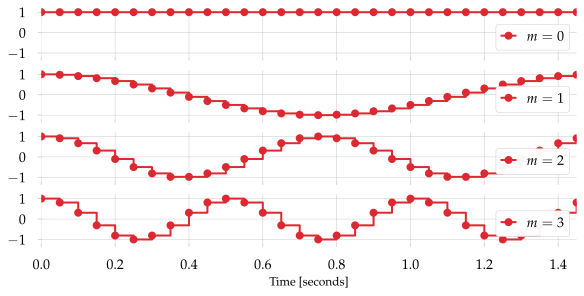

In [14]:
fig, ax = plt.subplots(nrows=4, sharex=True, sharey=True, figsize=figaspect(0.5))

fs = 20
N = 30

n = np.arange(N)
ax[0].step(n / fs, np.cos(2 * np.pi * 0 * n / N), marker='o', where='post', label=r'$m=0$', color=colors[1])
ax[0].label_outer()
ax[0].legend(loc='lower right')
ax[1].step(n / fs, np.cos(2 * np.pi * 1 * n / N), marker='o', where='post',label=r'$m=1$', color=colors[1])
ax[1].label_outer()
ax[1].legend(loc='lower right')
ax[2].step(n / fs, np.cos(2 * np.pi * 2 * n / N), marker='o', where='post',label=r'$m=2$', color=colors[1])
ax[2].label_outer()
ax[2].legend(loc='lower right')

ax[3].step(n / fs, np.cos(2 * np.pi * (3) * n / N), marker='o', where='post', label=r'$m=3$', color=colors[1])
ax[3].label_outer()
ax[3].legend(loc='lower right')

ax[3].set(xlabel='Time [seconds]', ylim=[-1.2, 1.2]);
glue('analysis-freqs', fig, display=False)

```{glue:figure} analysis-freqs

The first four analysis frequencies for a signal of duration 1.5 seconds.
```

If we continue this process a little further ($m= \dots, N-2, N-1, N, N+1, \dots$), what happens?

Let's take $m=N+1$ as an example.  In this case, we have

$$
\begin{align*}
f_{N+1} &= \frac{N+1}{N} \cdot f_s\\
&= \frac{N}{N}\cdot f_s + \frac{1}{N} \cdot f_s\\
&= f_s + \frac{1}{N} \cdot f_s\\
&= f_s + f_1.
\end{align*}
$$

This is our old friend, {ref}`aliasing <aliasing>`!
Analysis frequency $m=N+1$ gives us exactly the same samples as $m=1$ because they are related by the bandwidth of the signal $f_s$.
Comparing our signal $x$ to the reference signal for $m=N+1$ would therefore give us exactly the same similarity score as if we had compared to the $m=1$ signal.
So let's not bother with it!

More generally, for any $m \geq N$, the corresponding frequency will always have an alias given by $m \mod N$.
This answers our question: there are only $N$ such frequencies ($m=0,1,2, \dots, N-2, N-1$) which produce distinct reference signals.
How fortunate that this is exactly the same number as the length of our signal!

### A closer look at analysis frequencies

Now that we have our analysis frequencies chosen, it's worth taking a closer look to make sure we really understand what's going on.
The plot above shows the first few ($m=0,1,2,3$) but what happens for larger values?

Recall that we've assumed the signal $x[n]$ to be band-limited to satisfy the Nyquist-Shannon theorem, so it cannot contain energy from frequencys above $f_s/2$ (the Nyquist frequency).
The Nyquist frequency appears in our analysis frequencies (when $N$ is even, anyway) as $m=N/2$:

$$
f_{N/2} = \frac{N}{2N} \cdot f_s = \frac{f_s}{2},
$$

but $m$ itself can range all the way up to $N-1 > N/2$.

Again, aliasing can help us make sense of this.
When $N-1\geq m > N/2$, the corresponding frequency will lie outside the band limits of the signal.
However, it will have an alias within the band, which we can find by subtracting $f_s$:

$$
\begin{align*}
f_m - f_s &= \frac{m}{N} \cdot f_s - f_s\\
&= \frac{m}{N} \cdot f_s - \frac{N}{N} \cdot f_s\\
&= \frac{m-N}{N} \cdot f_s.
\end{align*}
$$

Since $m < N$, this will be a negative frequency, but that's okay!
The important thing is that it will be within the range $[-f_s/2, +f_s/2]$.

```{tip} 

Analysis frequencies for $m \geq N/2$ correspond to **negative frequencies**.
```

So far in this section, we've been assuming that the reference signals are produced by cosine waves, for which negative frequencies are indistinguishable from positive frequencies.  (Remember, $\cos(\theta) = \cos(-\theta)$.)
This means that the distinction isn't so important right now.
However, it will become important in the full context of the Fourier transform, which we will see in the following sections.

## Bringing it all together

To finish off this section, let's combine everything we've seen so far, and finally compare a signal $x[n]$ to a full collection of reference signals.
For each analysis frequency $f_m$, we'll compute a similarity score $S_m$, and the collection of scores $[S_0, S_1, \dots, S_{N-1}]$ will form the representation of our signal.
We'll use the same example signal as above, but we'll now focus on a single repetition of $x[n]$ rather than the infinitely repeating sequence.

The plot below shows the signal $x$, reference signals $y_m$ for $m = 0, 1, 2, \dots, 9$ in the left column.
The middle column shows the product of $x[n] \cdot y_m[n]$ for each reference signal $y_m$,
and the right column shows the resulting similarity scores.

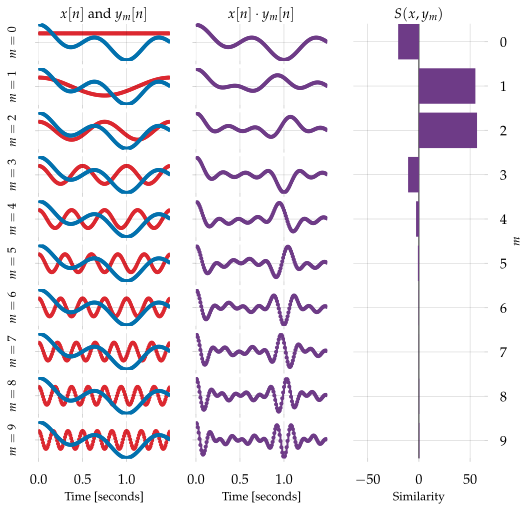

In [16]:
# Do the cosine transform
from matplotlib import gridspec

fig = plt.figure(figsize=figaspect(1))

M = 10

gs = gridspec.GridSpec(M, 3)

fs = 100
f0 = 1.5
f1 = 1/2
N = int(f0 * fs)
t = np.arange(N) / fs
x = np.cos(2 * np.pi * f0 * t) + np.cos(2 * np.pi * f1 * t)

xfft = np.fft.rfft(x).real

sharing = None
for i in range(M):
    ax1 = plt.subplot(gs[i, 0], sharex=sharing, sharey=sharing)
    
    ref = np.cos(2 * np.pi * i / N * fs * t)

    ax1.step(t, x, zorder=2, marker='.', where='post')
    ax1.step(t, ref, zorder=-1, marker='.', where='post')
    ax1.set_ylim([-2.05, 2.05])
    ax1.set_yticks([0])
    ax1.set_yticklabels([])
    ax1.set_ylabel('$m={:d}$'.format(i))
    ax1.label_outer();

    xsim = x * ref
    
    ax2 = plt.subplot(gs[i, 1], sharex=sharing, sharey=sharing)
    ax2.step(t, xsim, color=colors[4], label=r'$x[n] \cdot y_m[n]$', marker='.', where='post')
    ax2.set_yticks([0])
    ax2.set_ylim([-2.1, 2.1])
    ax2.label_outer();
    
    if i == 0:
        ax1.set_title('$x[n]$ and $y_m[n]$')
        ax2.set_title(r'$x[n] \cdot y_m[n]$')
    elif i == M - 1:
        ax1.set_xlabel('Time [seconds]')
        ax2.set_xlabel('Time [seconds]')
        
ax = plt.subplot(gs[:, 2])
ax.barh(np.arange(M), xfft[:M], color=colors[4])
ax.invert_yaxis();
ax.axvline(0, color=colors[3], zorder=-1, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set(title=r'$S(x, y_m)$', ylabel=r'$m$', yticks=range(M), xlim=[-64, 64], ylim=[9.4, -0.4], xlabel='Similarity');
glue('full-example', fig, display=False)

```{glue:figure} full-example

Left: a signal $x$ overlayed with the first 10 reference sinusoids.
Middle: the per-sample product.
Right: the resulting similarity scores for each reference sinusoid.
```

Showing all $N=150$ comparisons in the form above would take quite a bit of space, so we only show the first ten to illustrate the idea.

More frequently, we omit the center column, and go directly to the third column.
For our signal, if we show all $N$ similarity scores in one plot, it looks like this:

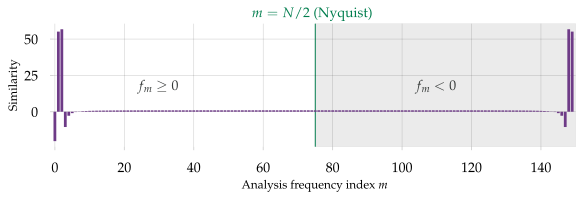

In [17]:
fig, ax = plt.subplots(figsize=figaspect(1./3))

# Our calculation above is just the real part of the DFT
xfft = np.fft.fft(x).real
ax.bar(np.arange(len(xfft)), xfft, color=colors[4])
ax.axvline(N/2, color=colors[5], zorder=-1, linewidth=1)
ax.axvspan(N/2, N, color=colors[3], alpha=0.1, zorder=-2)
ax.text(30, 15, '$f_m \geq 0$', color=colors[3], ha='center')
ax.text(110, 15, '$f_m < 0$', color=colors[3], ha='center')
ax.text(0.43, 0.93, '$m=N/2$ (Nyquist)', color=colors[5], transform=fig.transFigure)
ax.set(xlabel='Analysis frequency index $m$', ylabel='Similarity');
glue('spectrum', fig, display=False)

```{glue:figure} spectrum

A bar-plot illustrating the similarity score for the input signal compared to the full set of analysis frequencies.
Indices $m = 0, 1, ... N/2$ correspond to positive frequencies, and $m \geq N/2$ (shaded region) correspond to negative frequencies.
```

This kind of plot is called a **spectrum**.
By analogy to colors, you can think of the length of each bar as measuring "how much" of each frequency is present in the signal $x[n]$.
You may have encountered something like this previously, for example, in a music player application, digital audio workstation, or on a stereo system.

We'll have much more to say about frequency spectra in the following sections, but for now we'll leave it here.

## Summary

As mentioned at the top of this section, the process that we've just seen is **not quite** the Fourier transform, but we're almost there.

The key things to remember from this section:

1. We now assume that a signal $x[n]$ of $N$ samples will repeat indefinitely.
2. Analysis frequencies complete a whole number of cycles in $N$ samples.
3. We can represent a signal $x$ according in terms of its similarity to sinusoids at our chosen analysis frequencies.